In [5]:
%matplotlib inline
import pandas as pd
from ngramkit.common.w2v_model import W2VModel
from ngramkit.ngram_analyze.cosine_similarity_time_series import cosine_similarity_over_years
from ngramkit.ngram_analyze.weat_time_series import compute_weat_over_years
from ngramkit.ngram_analyze.semantic_drift import track_yearly_drift, compute_similarity_to_previous_year
from ngramkit.ngram_analyze.average_relatedness_by_year import track_word_semantic_drift

ModuleNotFoundError: No module named 'sklearn'

# **Analyze Semantic Change**
## **Goal**: Use trained `Word2vec` emeddings to examine semantic change over time. 

The `hist_w2v` package contains several tools useful in quantifying how much word meanings have changed over the years. Before using these tools, it helps to set a model path variable. Most commonly, this will point to the `norm_and_align` directory. We'll also set a `corpus_path` variable pointing to the yearly corpus data.

In [2]:
model_path =  '/vast/edk202/NLP_corpora/Google_Books/20200217/eng-us/5gram_files/6corpus/yearly_files/models_final/norm_and_align'
corpus_path = '/vast/edk202/NLP_corpora/Google_Books/20200217/eng-us/5gram_files/6corpus/yearly_files/data'

### `get_corpus_stats` function
For some analyses, it's useful to collect information about the training corpora—in particular, their sizes. The `corpus_stats` module does this. This can talk almost an hour, so the data get saved in the `out_dir` directory. Once the file has been created, you can regenerate it by setting `overwrite=True`. Otherwise, there is no need to run this function again; you can load the existing CSV file into a `pandas` data frame at any point.

In [4]:
df = get_corpus_stats(
    data_dir=corpus_path,
    out_dir=corpus_path,
    overwrite=True
)

Processing corpus files:   0%|          | 0/482 [00:00<?, ?file/s]

Statistics saved to /vast/edk202/NLP_corpora/Google_Books/20200217/eng-us/5gram_files/6corpus/yearly_files/data/corpus_stats.csv


In [5]:
df

,unique_ngrams,total_freq,total_docs
Year,,,
1472,7791,25413,12475
1475,21795,55147,38521
1476,1635,2369,2270
1477,4348,10107,6355
1478,16647,33220,25996
...,...,...,...
2015,72122123,1389986373,1211625146
2016,68465226,1323574126,1157209536
2017,60822656,1077285474,949582452


### `compare_words_cosim` method

Let's say we want to measure the relationship between three pairs of words — _horse_ and _donkey_, _horse_ and _lizard_ , and _horse_ and _amoeba_ — in the 2019 corpus. We first create a `W2VModel` instance for the 2019 embeddings. Then, we call the `compare_words_cosim` method for our words.

In [10]:
year = 2019
model = W2VModel(f'{model_path}/w2v_y{year}_wbnone_vs200_w5_mc10_sg1_e8.kv')

word1, word2 = 'horse', 'donkey'
similarity = model.compare_words_cosim(word1, word2)
print(f"cos(Φ) of \'{word1}\' and \'{word2}\' in {year} = {similarity:.4f}")

word1, word2 = 'horse', 'lizard'
similarity = model.compare_words_cosim(word1, word2)
print(f"cos(Φ) of \'{word1}\' and \'{word2}\' in {year} = {similarity:.4f}")

word1, word2 = 'horse', 'amoeba'
similarity = model.compare_words_cosim(word1, word2)
print(f"cos(Φ) of \'{word1}\' and \'{word2}\' in {year} = {similarity:.4f}")

cos(Φ) of 'horse' and 'donkey' in 2019 = 0.6735
cos(Φ) of 'horse' and 'lizard' in 2019 = 0.3004
cos(Φ) of 'horse' and 'amoeba' in 2019 = 0.2298


The results are about what would would expect!

### `compare_models_cosim` method
Suppose we want to compare the semantic similarity of the _same_ words across _models_. We can use the `compare_models_cosim` method to compute the average cosine similarity between shared words in two models. Or, if we specify the `word` parameter, we can compute similarity for a single word across the models.

In [12]:
model = W2VModel(f'{model_path}/w2v_y2018_wbnone_vs200_w5_mc10_sg1_e8.kv')
reference_model = W2VModel(f'{model_path}/w2v_y2019_wbnone_vs200_w5_mc10_sg1_e8.kv')

cosim_mean, cosim_sd, shared_words = model.compare_models_cosim(reference_model)
print(f"Overall similarity between models:\n  cos(Φ) mean = {cosim_mean:.4f}\n  cos(Φ) SD = {cosim_sd:.4f}\n  shared words: {shared_words}\n")

word = 'horse'
cosim, _, _ = model.compare_models_cosim(reference_model, word)
print(f"Similarity of \'{word}\' between models:\n  cos(Φ) = {cosim:.4f}\n")

Overall similarity between models:
  cos(Φ) mean = 0.8006
  cos(Φ) SD = 0.0775
  shared words: 72441

Similarity of 'horse' between models:
  cos(Φ) = 0.8982



### `track_yearly_drift` function

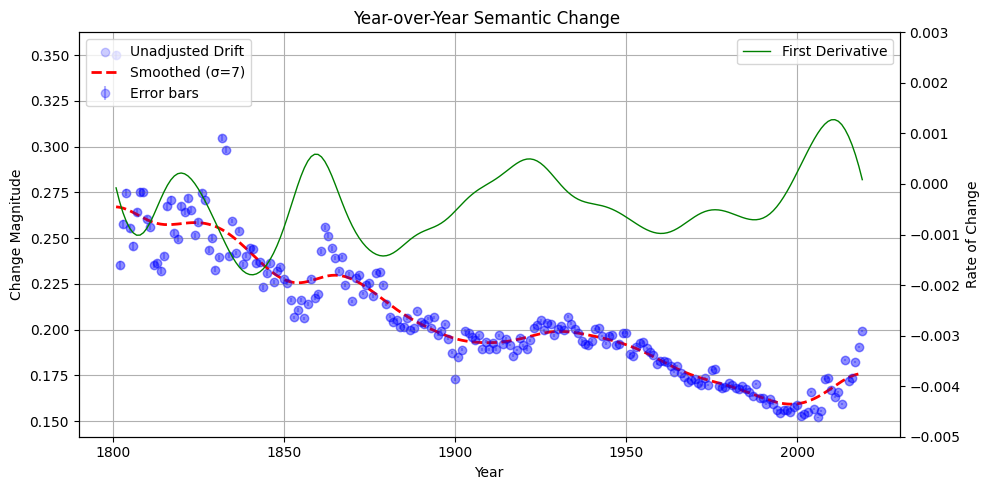

In [15]:
drift_scores = track_yearly_drift(
    start_year=1800,
    end_year=2019,
    model_dir=model_path,
    plot=True,
    error_type='CI',
    smooth=True,
    sigma=7,
    confidence=0.99
)

show(drift_scores)

In [17]:
df_regressors = pd.read_csv(f"{corpus_path}/corpus_stats.csv", index_col="Year")
df_regressors

,unique_ngrams,total_freq,total_docs
Year,,,
1472,7791,25413,12475
1475,21795,55147,38521
1476,1635,2369,2270
1477,4348,10107,6355
1478,16647,33220,25996
...,...,...,...
2015,72122123,1389986373,1211625146
2016,68465226,1323574126,1157209536
2017,60822656,1077285474,949582452


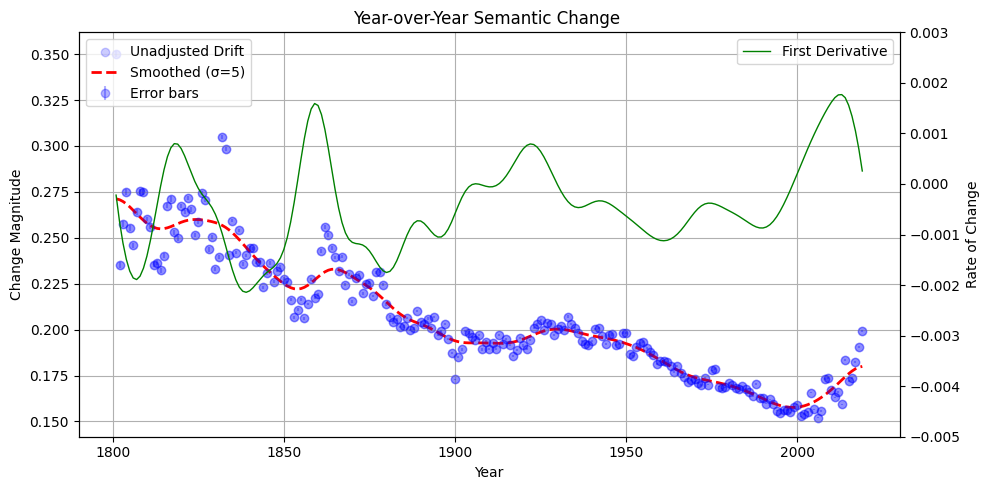

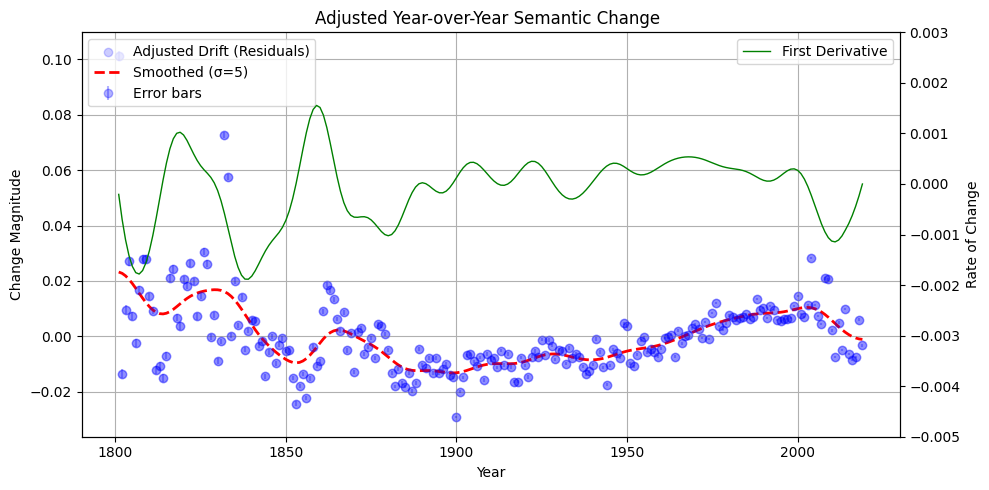

In [18]:
df_results = track_yearly_drift(
    start_year=1800, 
    end_year=2019, 
    model_dir=model_path,
    plot=True, 
    smooth=True, 
    sigma=5,
    df=df_regressors,
    regress_on="unique_ngrams"
)

### `mean_cosine_similarity_to_all` class

In [4]:
model = W2VModel(f'{model_path}/w2v_y2019_wbnone_vs200_w5_mc10_sg1_e8.kv')

mean_sim = model.mean_cosine_similarity_to_all('person', '')
print(f"Mean cosine similarity = {mean_sim:.4f}")

Mean cosine similarity = 0.1658


Tracking semantic drift for word: 'machine' (Excluding: 0 words)


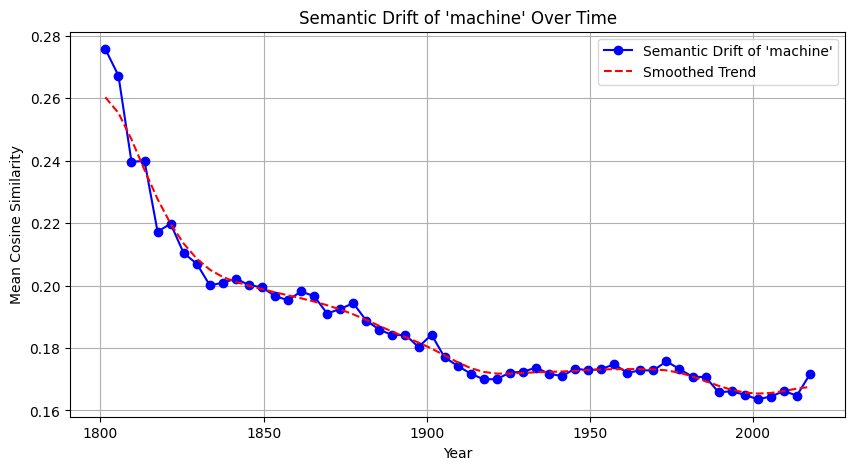

{1800: (0.21672153881806408, 0),
 1801: (0.3112783485143988, 0),
 1802: (0.30101244648498127, 0),
 1803: (0.2736203586085016, 0),
 1804: (0.26084447564897667, 0),
 1805: (0.2662901125593569, 0),
 1806: (0.28596027414718583, 0),
 1807: (0.2558094987527339, 0),
 1808: (0.25131843864551145, 0),
 1809: (0.23677867612711337, 0),
 1810: (0.2274190628627829, 0),
 1811: (0.24305891144777322, 0),
 1812: (0.242049012138077, 0),
 1813: (0.24167467222448513, 0),
 1814: (0.246053677499134, 0),
 1815: (0.22964330397987048, 0),
 1816: (0.2159544068392155, 0),
 1817: (0.2279925687005668, 0),
 1818: (0.21671704707353864, 0),
 1819: (0.20834337119280325, 0),
 1820: (0.23309420654483967, 0),
 1821: (0.21843461391142896, 0),
 1822: (0.20923214430195666, 0),
 1823: (0.21832876861166584, 0),
 1824: (0.21405103784257762, 0),
 1825: (0.20635517210656798, 0),
 1826: (0.2125444471678776, 0),
 1827: (0.20851307620572238, 0),
 1828: (0.21523114435085314, 0),
 1829: (0.20763303446681716, 0),
 1830: (0.196867042530

In [11]:
track_word_semantic_drift(
    word='machine',
    start_year=1800,
    end_year=2019,
    model_dir=f'{model_path}',
    plot=4,
    smooth=True,
    sigma=2
)

### `cosine_similarity_over_years` function

The `cosine_similarity_time_series` function uses the `compare_words_cosim` method to track the relationship between a pair of words across time. Simply specify your two words (`word1` and `word2`), a `start_year` and `end_year`, and the model directory. You'll get a list of years and associated cosine similarities; set `plot=True` if you want to graph them. The model will skip any years for which there is no model or there words aren't in the models' shared vocabulary.

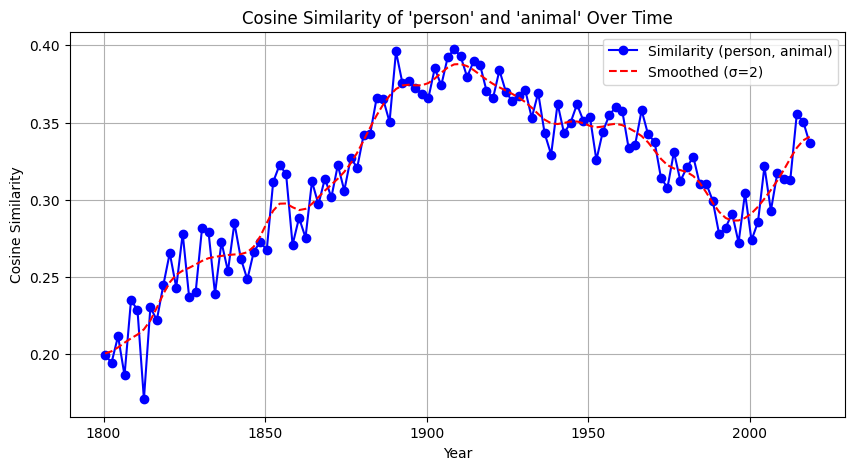

{1800: 0.21762453,
 1801: 0.1804999,
 1802: 0.14745988,
 1803: 0.24148168,
 1804: 0.25458795,
 1805: 0.16859092,
 1806: 0.20294644,
 1807: 0.16944939,
 1808: 0.26542428,
 1809: 0.20394637,
 1810: 0.26199892,
 1811: 0.19547604,
 1812: 0.17837748,
 1813: 0.16301557,
 1814: 0.2592309,
 1815: 0.20114699,
 1816: 0.2649214,
 1817: 0.17913133,
 1818: 0.20723681,
 1819: 0.281934,
 1820: 0.26694557,
 1821: 0.26389608,
 1822: 0.22455847,
 1823: 0.2615888,
 1824: 0.2512267,
 1825: 0.30487794,
 1826: 0.22435533,
 1827: 0.24905251,
 1828: 0.23156382,
 1829: 0.248163,
 1830: 0.28817016,
 1831: 0.27560133,
 1832: 0.29943684,
 1833: 0.2582505,
 1834: 0.27095744,
 1835: 0.2070934,
 1836: 0.29799503,
 1837: 0.24694967,
 1838: 0.23544866,
 1839: 0.2719501,
 1840: 0.26897946,
 1841: 0.30071062,
 1842: 0.23468497,
 1843: 0.2888275,
 1844: 0.27008677,
 1845: 0.22658883,
 1846: 0.28234297,
 1847: 0.25021,
 1848: 0.2585423,
 1849: 0.2869682,
 1850: 0.25357974,
 1851: 0.2810438,
 1852: 0.31492755,
 1853: 0.308

In [12]:
cosine_similarity_over_years(
    word1='person',
    word2='animal',
    start_year=1800,
    end_year=2019,
    model_dir=f'{model_path}',
    plot=2,
    smooth=True,
    sigma=2
)

### `compute_weat` method
This method runs a Word Embedding Association Test (WEAT) as described in [Caliskan, Bryson, and Narayanan, 2017](https://www.science.org/doi/10.1126/science.aal4230). The WEAT is a close analog of the Implicit Association Test (IAT; [Greenwald, McGhee, & Schwarz, 1995](https://psycnet.apa.org/record/1998-02892-004))—but, whereas the IAT uses reaction latencies to measure a person's cognitive association between two mental category constrasts, the WEAT uses cosine similarities to measure the semantic association between linguistic category contrasts in a corpus.

Just as with the IAT, the WEAT requires that you select two constrasting "target" categories (e.g., _man_ vs. _woman_) and two contrasting "attribute" categories (e.g., _science_ vs. _art_), as well as a list of exemplars of each of these four categories. The `compute_weat` method then:
1. calculates the mean of all pairwise cosine similarities among exemplars within each target–attribute combination (e.g., $\bar c_{man, science}$, $\bar c_{man, art}$, $\bar c_{woman, science}$, $\bar c_{woman, art}$),
2. takes the difference in mean similarity between combinations involving the same target (e.g., $\bar c_{man, science} - \bar c_{man, art}$ and $\bar c_{woman, science} - \bar c_{woman, art}$),
3. subtracts these differences from one another (e.g., $[(\bar c_{man, science} - \bar c_{man, art}) - (\bar c_{woman, science} - \bar c_{woman, art})]$), and
4. divides this difference by the pooled standard deviation across all exemplars for all target–attribute pairs.

This calculation yields an effect size, $d$, analogous to that used in IAT research. Higher scores indicate a stronger relative semantic link between the first target and first attribute (e.g., between _man_ and _science_).

In [14]:
model = W2VModel(f'{model_path}/w2v_y2019_wbnone_vs200_w5_mc10_sg1_e8.kv')

target1 = ["man", "male", "boy", "father", "brother"]
target2 = ["woman", "female", "girl", "mother", "sister"]
attribute1 = ["science", "technology", "chemistry"]
attribute2 = ["art", "literature", "poetry", "painting"]

weat_score, p = model.compute_weat(target1, target2, attribute1, attribute2)
print(f"WEAT effect size (Cohen's d) = {weat_score:.4f}, p = {p:.4f}")

WEAT effect size (Cohen's d) = 0.3704, p = 0.1557


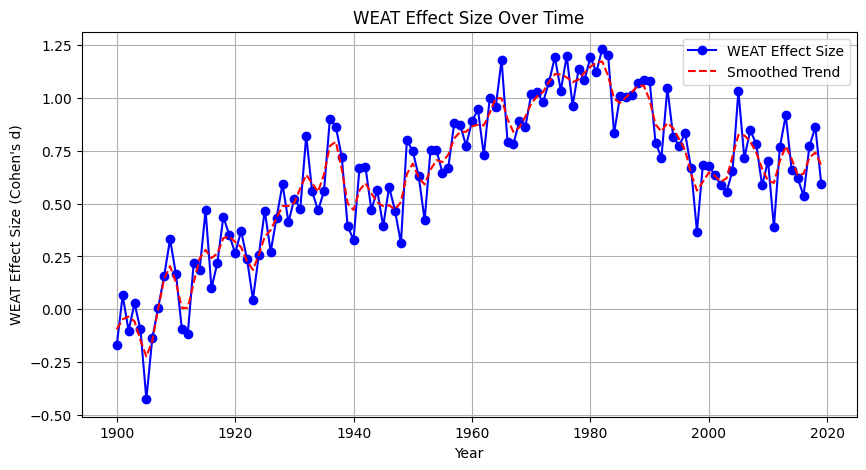

{1900: (-0.16930994, None, None),
 1901: (0.065056704, None, None),
 1902: (-0.102127366, None, None),
 1903: (0.027743991, None, None),
 1904: (-0.09522114, None, None),
 1905: (-0.42660645, None, None),
 1906: (-0.13738257, None, None),
 1907: (0.007444409, None, None),
 1908: (0.15556943, None, None),
 1909: (0.33113867, None, None),
 1910: (0.1658967, None, None),
 1911: (-0.093706876, None, None),
 1912: (-0.11656001, None, None),
 1913: (0.21948509, None, None),
 1914: (0.18571709, None, None),
 1915: (0.468292, None, None),
 1916: (0.09860653, None, None),
 1917: (0.22021717, None, None),
 1918: (0.43766692, None, None),
 1919: (0.35235673, None, None),
 1920: (0.26577258, None, None),
 1921: (0.36980766, None, None),
 1922: (0.2384915, None, None),
 1923: (0.045748424, None, None),
 1924: (0.25810304, None, None),
 1925: (0.4666185, None, None),
 1926: (0.27232262, None, None),
 1927: (0.43428272, None, None),
 1928: (0.59225196, None, None),
 1929: (0.41278642, None, None),
 1

In [23]:
target1 = ["socialism", "socialist"]
target2 = ["capitalism", "capitalist"]
attribute1 = ["good", "ideal", "wonderful", "excellent", "great", "fantastic", "amazing", "superb", "outstanding", "marvelous", "splendid", "brilliant", "fabulous", "terrific", "admirable", "commendable", "exemplary", "praiseworthy", "superior", "stellar", "notable", "positive", "advantageous", "desirable"]
attribute2 = ["bad", "evil", "destructive", "terrible", "horrible", "awful", "dreadful", "abysmal", "atrocious", "appalling", "ghastly", "wicked", "villainous", "corrupt", "harmful", "damaging", "deplorable", "noxious", "pernicious", "heinous", "malevolent", "diabolical", "negative", "undesirable"]

compute_weat_over_years(
    target1,
    target2,
    attribute1,
    attribute2,
    start_year=1900,
    end_year=2019,
    model_dir="/vast/edk202/NLP_corpora/Google_Books/20200217/eng-us/5gram_files/6corpus/yearly_files/models_final/norm_and_align/",
    num_permutations=0,
    plot=1,
    smooth=True,
    sigma=1,
    return_std=False
)